In [1]:
!pwd

/home/dinh/graph-based_action-recognition/data_generator/utils


In [2]:
%cd ../..

/home/dinh/graph-based_action-recognition


In [26]:
import numpy as np

def normalize_view(seq_info):
    for frame in seq_info:
        for body in frame:
            joints = body.joints
            
            # 3D shoulder coordinates
            right_shoulder = np.array([
                joints[4].orientationX,
                joints[4].orientationY,
                joints[4].orientationZ
            ])
            left_shoulder = np.array([
                joints[8].orientationX,
                joints[8].orientationY,
                joints[8].orientationZ
            ])
            # Compute vector from right to left shoulder
            v_shoulder = left_shoulder - right_shoulder
            norm = np.linalg.norm(v_shoulder)
            if norm == 0:
                continue  # Skip if the vector is invalid

            v_shoulder = v_shoulder / norm  # Normalize

            # Desired direction (global X-axis)
            x_axis = np.array([1, 0, 0])

            # Compute rotation axis and angle
            axis = np.cross(v_shoulder, x_axis)
            angle = np.arccos(np.clip(np.dot(v_shoulder, x_axis), -1.0, 1.0))
            if np.linalg.norm(axis) < 1e-6:
                continue  # Already aligned

            axis = axis / np.linalg.norm(axis)

            # Rotation matrix using Rodrigues' formula
            K = np.array([[0, -axis[2], axis[1]],
                          [axis[2], 0, -axis[0]],
                          [-axis[1], axis[0], 0]])
            R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * (K @ K)

            # Rotate all joints
            for joint in joints:
                joint_vec = np.array([joint.orientationX, joint.orientationY, joint.orientationZ])
                rotated_vec = R @ joint_vec
                joint.orientationX, joint.orientationY, joint.orientationZ = rotated_vec.tolist()

    return seq_info

In [27]:
def pre_process(seq_info, max_frames=300):
    # Step 1: Extract valid (non-empty) frames
    valid_frames_list = [frame for frame in seq_info if len(frame) > 0]
    
    if not valid_frames_list:
        raise ValueError("No valid frames found in the sequence.")
    
    # Step 2: Pad with repeated valid frames if not enough
    padded_seq = []
    while len(padded_seq) < max_frames:
        for frame in valid_frames_list:
            padded_seq.append(frame)
            if len(padded_seq) == max_frames:
                break

    # Step 3: Normalize joints by subtracting spine joint (joint index 1)
    for frame in padded_seq:
        for body in frame:
            joints = body.joints
            
            spine = joints[1]
            for joint in joints:
                joint.colorX -= spine.colorX
                joint.colorY -= spine.colorY
                # joint.depthX -= spine.depthX
                # joint.depthY -= spine.depthY
                # joint.cameraX -= spine.cameraX
                # joint.cameraY -= spine.cameraY
                # joint.cameraZ -= spine.cameraZ
                
    normalized_seq = normalize_view(padded_seq)
    return normalized_seq


In [28]:
%matplotlib widget

"""
Illustrate skeletons from a .skeleton file of the "NTU RGB+D 3D Action Recognition Dataset"

Argument:
    filename: full adress and filename of the .skeleton file.
"""

import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from ipywidgets import Button, IntSlider, HBox, VBox
from IPython.display import display
from data_generator.utils.read_skeleton_file import read_skeleton_file


"""
In the skeleton structure, each joint is connected to some other joints. To faciliate the illustration, we suppose that each joint has 
only one neighbor.

For further information, please refer to:
    NTU RGB+D dataset's webpage:
       http://rose1.ntu.edu.sg/Datasets/actionRecognition.asp
    NTU RGB+D dataset's github page:
       https://github.com/shahroudy/NTURGB-D
""" 
CONNECTING_JOINT = [2, 1, 21, 3, 21, 5, 6, 7, 21, 9, 10, 11,
                    1, 13, 14, 15, 1, 17, 18, 19, 2, 8, 8, 12, 12]

def draw_frame(ax, bodies, zoom_factor):
    ax.clear()
    ax.axis('off')
    width = 1920 / zoom_factor
    height = 1080 / zoom_factor
    ax.set_xlim((1920 - width) / 2, (1920 + width) / 2)
    ax.set_ylim((1080 + height) / 2, (1080 - height) / 2)
    for body in bodies:
        joints = body.joints
        for j in range(25):
            k = CONNECTING_JOINT[j] - 1
            if 0 <= k < 25:
                x1, y1 = joints[j].colorX, joints[j].colorY
                x2, y2 = joints[k].colorX, joints[k].colorY
                ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
        for joint in joints:
            ax.scatter(joint.colorX, joint.colorY, c='red', s=20)

def display_widget(filename, pre_processing=False):
    # --- Load skeleton data ---
    skeleton_data = read_skeleton_file(filename)
    if pre_processing:
            skeleton_data = pre_process(skeleton_data)
            print(len(skeleton_data))
    total_frames = len(skeleton_data)

    # --- Global state ---
    state = {
        "current_frame": 1,
        "zoom_factor": 1.0,
        "is_playing": True,
        "slider_is_moving": False
    }

    fig, ax = plt.subplots(figsize=(8, 4.5))

    # --- Update frame ---
    def update(frame):
        state["current_frame"] = frame
        draw_frame(ax, skeleton_data[frame - 1], state["zoom_factor"])
        ax.set_title(f"Frame: {frame} / {total_frames}")
        if not state["slider_is_moving"]:
            frame_slider.value = frame

    anim = FuncAnimation(fig, update, frames=range(1, total_frames + 1), interval=100)
    anim.event_source.stop()

    # --- Button callbacks ---
    def on_play_pause_clicked(b):
        if state["is_playing"]:
            anim.event_source.stop()
            b.description = "Play"
        else:
            anim.event_source.start()
            b.description = "Pause"
        state["is_playing"] = not state["is_playing"]

    def on_step_clicked(b):
        if state["current_frame"] < total_frames:
            state["current_frame"] += 1
            anim.event_source.stop()
            play_pause_btn.description = "Play"
            update(state["current_frame"])
            state["is_playing"] = False

    def on_replay_clicked(b):
        # Reset state
        state["current_frame"] = 1
        state["zoom_factor"] = 1.0
        state["is_playing"] = True
        anim.event_source.stop()
        play_pause_btn.description = "Play"
        update(1)

    def on_zoom_in_clicked(b):
        state["zoom_factor"] *= 1.25
        update(state["current_frame"])

    def on_zoom_out_clicked(b):
        state["zoom_factor"] /= 1.25
        update(state["current_frame"])

    def on_save_gif_clicked(b):
        gif_name = os.path.splitext(os.path.basename(filename))[0] + ".gif"
        print(f"Saving animation to {gif_name}...")
        temp_anim = FuncAnimation(fig, update, frames=range(1, total_frames + 1), interval=100, repeat=False)
        temp_anim.save(gif_name, writer=PillowWriter(fps=10))
        print("GIF saved successfully.")

    def on_close_clicked(b):
        anim.event_source.stop()
        plt.close(fig)

    def on_frame_slider_change(change):
        if change['name'] == 'value':
            state["slider_is_moving"] = True
            new_frame = change['new']
            if new_frame != state["current_frame"]:
                state["current_frame"] = new_frame
                anim.event_source.stop()
                play_pause_btn.description = "Play"
                state["is_playing"] = False
                update(new_frame)
            state["slider_is_moving"] = False

    # --- Widgets ---
    play_pause_btn = Button(description="Pause")
    play_pause_btn.on_click(on_play_pause_clicked)

    step_btn = Button(description="Step")
    step_btn.on_click(on_step_clicked)

    replay_btn = Button(description="Replay")
    replay_btn.on_click(on_replay_clicked)

    zoom_in_btn = Button(description="Zoom In")
    zoom_in_btn.on_click(on_zoom_in_clicked)

    zoom_out_btn = Button(description="Zoom Out")
    zoom_out_btn.on_click(on_zoom_out_clicked)

    save_gif_btn = Button(description="Save GIF")
    save_gif_btn.on_click(on_save_gif_clicked)

    close_btn = Button(description="Close")
    close_btn.on_click(on_close_clicked)

    frame_slider = IntSlider(value=1, min=1, max=total_frames, description='Frame')
    frame_slider.observe(on_frame_slider_change, names='value')

    controls = HBox([
        play_pause_btn, step_btn, replay_btn,
        zoom_in_btn, zoom_out_btn, save_gif_btn,
        close_btn
    ])

    ui = VBox([controls, frame_slider])
    display(ui)

def draw_skeleton(filename: str, pre_processing = False, save: bool = False):
    if save:
        print("Saving directly to GIF...")
        skeleton_data = read_skeleton_file(filename)
        if pre_processing:
            skeleton_data = pre_process(skeleton_data)
            print(len(skeleton_data))
            
        fig, ax = plt.subplots(figsize=(8, 4.5))
        def update(frame):
            draw_frame(ax, skeleton_data[frame - 1], zoom_factor=1.0)
            ax.set_title(f"Frame: {frame} / {len(skeleton_data)}")
        anim = FuncAnimation(fig, update, frames=range(1, len(skeleton_data) + 1), interval=100, repeat=False)
        gif_name = os.path.splitext(os.path.basename(filename))[0] + ".gif"
        anim.save(gif_name, writer=PillowWriter(fps=10))
        print(f"GIF saved to: {gif_name}")
    else:
        display_widget(filename, pre_processing)


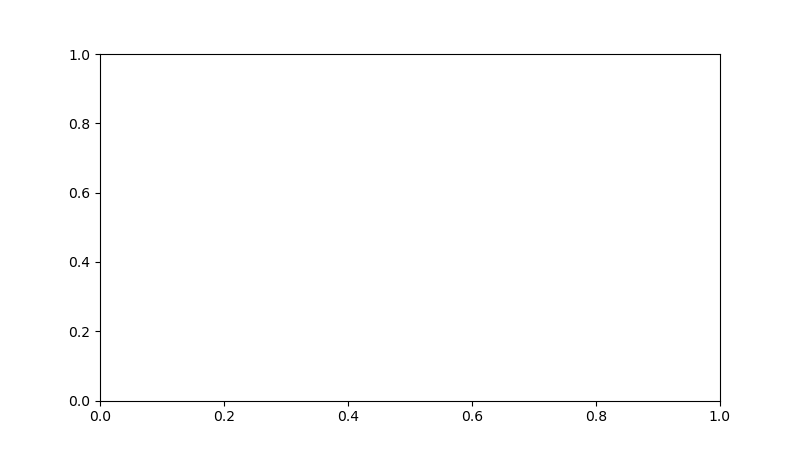

In [30]:
draw_skeleton('data/nturgb+d_skeletons/S001C001P001R001A002.skeleton', save=False)

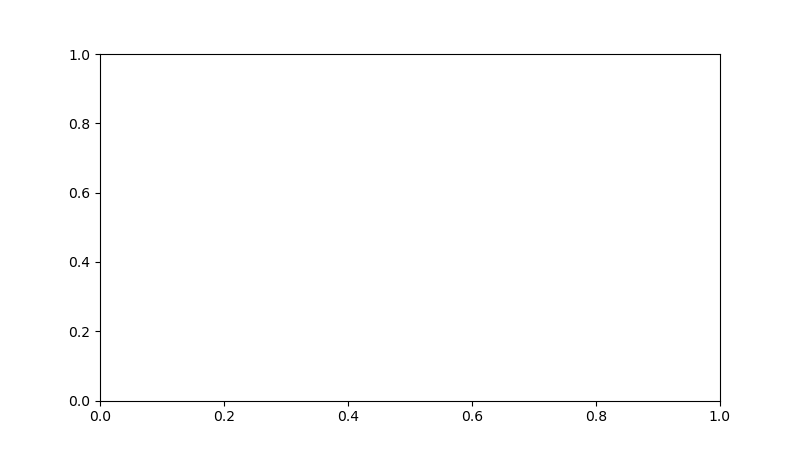

In [61]:
draw_skeleton('data/nturgb+d_skeletons/S001C001P001R001A060.skeleton', save=False)

In [92]:
%matplotlib widget

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from ipywidgets import Button, IntSlider, HBox, VBox
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from data_generator.utils.read_skeleton_file import read_skeleton_file
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define connection map between joints
CONNECTING_JOINT = [2, 1, 21, 3, 21, 5, 6, 7, 21, 9, 10, 11,
                    1, 13, 14, 15, 1, 17, 18, 19, 2, 8, 8, 12, 12]

def draw_frame_3d(ax, bodies, zoom_factor=1.0):
    ax.clear()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Assign distinct colors to bodies
    cmap = cm.get_cmap('tab10')  # 10 distinct colors
    num_bodies = len(bodies)
    
    drawn = False
    for i, body in enumerate(bodies):
        joints = getattr(body, "joints", [])
        if not joints or len(joints) != 25:
            continue

        color = cmap(i % 10)  # Cycle if more than 10 bodies

        xs = np.array([joint.x for joint in joints])
        ys = np.array([joint.z for joint in joints])       # Z as vertical
        zs = np.array([joint.y for joint in joints])      # Flip Y-axis

        # Center skeleton at spine base (joint 0)
        center = np.array([xs[0], ys[0], zs[0]])
        xs -= center[0]
        ys -= center[1]
        zs -= center[2]

        ax.scatter(xs, ys, zs, c=[color], s=20)
        for j in range(25):
            k = CONNECTING_JOINT[j] - 1
            if 0 <= k < 25:
                ax.plot([xs[j], xs[k]], [ys[j], ys[k]], [zs[j], zs[k]], color=color, linewidth=2)

        drawn = True

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)

    if not drawn:
        ax.set_title("No valid joint data to draw")

def display_widget_3d(filename, pre_processing=False):
    skeleton_data = read_skeleton_file(filename)
    if pre_processing:
        skeleton_data = pre_process(skeleton_data)
    total_frames = len(skeleton_data)

    state = {
        "current_frame": 1,
        "zoom_factor": 1.0,
        "is_playing": True,
        "slider_is_moving": False
    }

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def update(frame):
        state["current_frame"] = frame
        draw_frame_3d(ax, skeleton_data[frame - 1], state["zoom_factor"])
        ax.set_title(f"Frame: {frame} / {total_frames}")
        if not state["slider_is_moving"]:
            frame_slider.value = frame

    anim = FuncAnimation(fig, update, frames=range(1, total_frames + 1), interval=100)
    anim.event_source.stop()

    # Button callbacks
    def on_play_pause_clicked(b):
        if state["is_playing"]:
            anim.event_source.stop()
            b.description = "Play"
        else:
            anim.event_source.start()
            b.description = "Pause"
        state["is_playing"] = not state["is_playing"]

    def on_step_clicked(b):
        if state["current_frame"] < total_frames:
            state["current_frame"] += 1
            anim.event_source.stop()
            play_pause_btn.description = "Play"
            update(state["current_frame"])
            state["is_playing"] = False

    def on_replay_clicked(b):
        state["current_frame"] = 1
        state["zoom_factor"] = 1.0
        state["is_playing"] = True
        anim.event_source.stop()
        play_pause_btn.description = "Play"
        update(1)

    def on_zoom_in_clicked(b):
        state["zoom_factor"] *= 1.25
        update(state["current_frame"])

    def on_zoom_out_clicked(b):
        state["zoom_factor"] /= 1.25
        update(state["current_frame"])

    def on_save_gif_clicked(b):
        gif_name = os.path.splitext(os.path.basename(filename))[0] + "_3d.gif"
        print(f"Saving animation to {gif_name}...")
        temp_anim = FuncAnimation(fig, update, frames=range(1, total_frames + 1), interval=100, repeat=False)
        temp_anim.save(gif_name, writer=PillowWriter(fps=10))
        print("GIF saved successfully.")

    def on_close_clicked(b):
        anim.event_source.stop()
        plt.close(fig)

    def on_frame_slider_change(change):
        if change['name'] == 'value':
            state["slider_is_moving"] = True
            new_frame = change['new']
            if new_frame != state["current_frame"]:
                state["current_frame"] = new_frame
                anim.event_source.stop()
                play_pause_btn.description = "Play"
                state["is_playing"] = False
                update(new_frame)
            state["slider_is_moving"] = False

    # Widgets
    play_pause_btn = Button(description="Pause")
    play_pause_btn.on_click(on_play_pause_clicked)

    step_btn = Button(description="Step")
    step_btn.on_click(on_step_clicked)

    replay_btn = Button(description="Replay")
    replay_btn.on_click(on_replay_clicked)

    zoom_in_btn = Button(description="Zoom In")
    zoom_in_btn.on_click(on_zoom_in_clicked)

    zoom_out_btn = Button(description="Zoom Out")
    zoom_out_btn.on_click(on_zoom_out_clicked)

    save_gif_btn = Button(description="Save GIF")
    save_gif_btn.on_click(on_save_gif_clicked)

    close_btn = Button(description="Close")
    close_btn.on_click(on_close_clicked)

    frame_slider = IntSlider(value=1, min=1, max=total_frames, description='Frame')
    frame_slider.observe(on_frame_slider_change, names='value')

    controls = HBox([
        play_pause_btn, step_btn, replay_btn,
        zoom_in_btn, zoom_out_btn, save_gif_btn,
        close_btn
    ])

    ui = VBox([controls, frame_slider])
    display(ui)

def draw_skeleton_3d(filename: str, pre_processing=False, save=False):
    skeleton_data = read_skeleton_file(filename)
    if pre_processing:
        skeleton_data = pre_process(skeleton_data)

    if save:
        print("Saving directly to GIF...")
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        def update(frame):
            draw_frame_3d(ax, skeleton_data[frame - 1], zoom_factor=1.0)
            ax.set_title(f"Frame: {frame} / {len(skeleton_data)}")

        anim = FuncAnimation(fig, update, frames=range(1, len(skeleton_data) + 1), interval=100, repeat=False)
        gif_name = os.path.splitext(os.path.basename(filename))[0] + "_3d.gif"
        anim.save(gif_name, writer=PillowWriter(fps=10))
        print(f"GIF saved to: {gif_name}")
    else:
        display_widget_3d(filename, pre_processing)


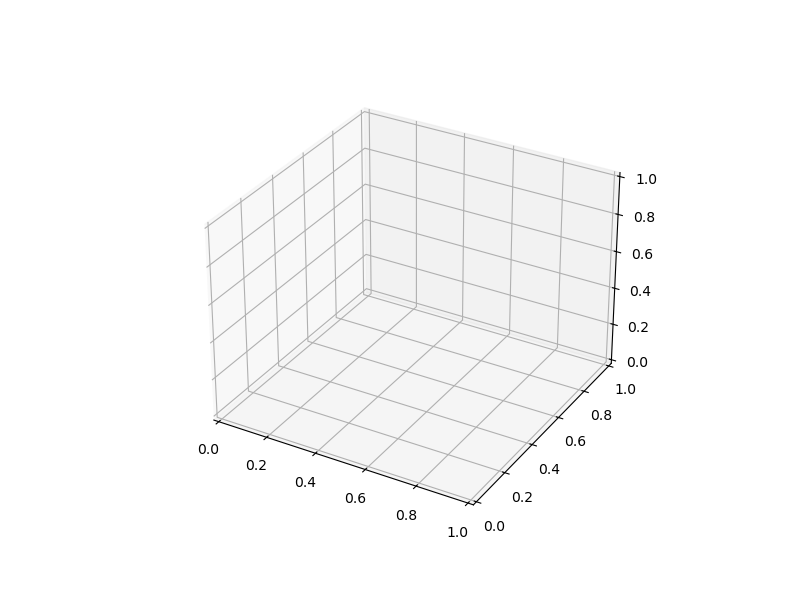

In [93]:
draw_skeleton_3d('data/nturgb+d_skeletons/S001C001P001R001A060.skeleton', pre_processing=True, save=False)